# Experiment 3: The Faucett Coefficient

A Custom coefficient designed to be more lenient on answers.

**faucett coefficient**
$$
K(p) = (\frac{\lvert X \cap Y \rvert}{\lvert X \cup Y \rvert})^{p},\ where\ 0.5 \leq p < 1
$$

The idea is you want to take a power greater than 0.5 and less than 1 of the ratio between the overlapping words and the combined words of both sets.

Taking the power means that relatively low overlap scores like 0.1 will generally be scored more highly 0.1^{1/2} = 0.31 for example.

Also by putting the union of both sentences' words in the denominator, we are still penalizing for longer sentences which have less overlap.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
import exp_libs.word_overlap as wo
import libs.preprocessing as pp
import libs.stats as stats
import libs.utils as utils
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Load Dataset
df_en = pd.read_csv("../../../datasets/final/en/asag_v2_en_filter.csv", sep='~')
print(len(df_en))
df_en.head(1)

2010


ID  AID  QID                                             Prompt  \
0  1.1    1    1   What is the role of a prototype program in pr...   

                                                  MA  \
0   To simulate the behaviour of portions of the ...   

                                                 MA2  \
0  to provide an example and feedback of how the ...   

                                                 MA3  \
0  to serve as a proof of concept and illustrate ...   

                               NA  \
0  to find errors or collect data   

                                                  SA  MyScore  \
0   High risk problems are address in the prototy...        4   

           Feedback Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect            NaN    3.5             2             1

Stored 'exp4_data' (dict)
             precision    recall  f1-score   support

        0.0       0.05      1.00      0.10        14
        1.0       0.01      0.25      0.02         8
        2.0       0.10      0.39      0.16       234
        3.0       0.03      0.08      0.04       157
        4.0       0.09      0.02      0.03       676
        5.0       0.87      0.02      0.04       921

avg / total       0.44      0.08      0.05      2010

Pearson's R: 0.4018879051085752
Cohen's Kappa: -0.02602381393087172
MAE: 2.1248756218905474
Accuracy: 7.66%
Precision: 44.37%
Recall: 7.66%
F1-Measure: 5.38%


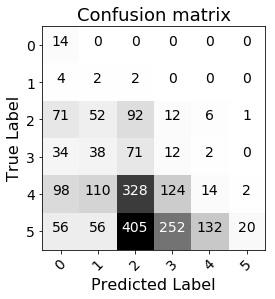

In [3]:
pipeline_phases = { 'case_normalization' : pp.case_normalization,
                    'punctuation_removal' : pp.punctuation_removal,
                    'remove_stopwords' : pp.create_remove_stopwords(pp.EN_STOPS),
                    'stemming' : pp.create_stemmer(pp.EN_STEMMER)}

pipeline = pp.create_pipeline(pipeline_phases, pp.whitespace_tokenize)

results = wo.execute_word_overlap_model(df_en, pipeline, wo.faucett_coefficient)

exp4_data = stats.get_all_stats(results['y_true'], results['y_pred'])
%store exp4_data

stats.print_all_stats(results['y_true'], results['y_pred'])
stats.plot_confusion_matrix(stats.cm(results['y_true'], results['y_pred']), classes=np.arange(6))

Stored 'exp4_data_pf' (dict)
             precision    recall  f1-score   support

          0       0.29      0.88      0.44       477
          1       0.90      0.34      0.49      1533

avg / total       0.76      0.47      0.48      2010

Pearson's R: 0.20920089016248575
Cohen's Kappa: 0.13160826498836165
MAE: 0.47562189054726367
Accuracy: 46.87%
Precision: 75.84%
Recall: 46.87%
F1-Measure: 48.13%


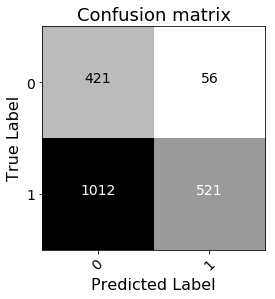

In [4]:
## Pass/Fail Evaluation
yt_pf = utils.convert_to_pass_fail(results['y_pred'])

exp4_data_pf = stats.get_all_stats(df_en['Class2_Score'], yt_pf)
%store exp4_data_pf

stats.print_all_stats(df_en['Class2_Score'], yt_pf)
stats.plot_confusion_matrix(stats.cm(df_en['Class2_Score'], yt_pf), classes=np.arange(2))

### H1 Evaluation:

1. answers which have a lot of tokens in common with model answer have high/correct scores

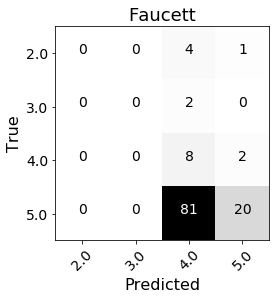

In [7]:
reload(stats)
idxs = results['y_pred_raw'] > 0.75
klasses = np.unique(results['y_true'][idxs])
stats.plot_confusion_matrix(stats.cm(results['y_true'][idxs], results['y_pred'][idxs]), classes=klasses, title='Faucett', savefile='../renderings/faucett')

In [11]:
reload(wo)
# inspecting false friends i.e. high overlap items which have low scores
idxs2 = np.logical_and(results['y_pred_raw'] > 0.75, results['y_true'] <= 3.0)

wo.inspect_results(df_en, results['y_true'], results['y_pred'], idxs2, results['sets'], size=5)

Prompt:  Order the following functions by their running time: n to the power of 2; log -LRB- log n -RRB- ; 2 to the power of -LRB- log n -RRB- ; n!; n to the power of 3. 
Score: 3.0, Score-Pred: 4
MA:  log -LRB- log n -RRB- ; 2 to the power of -LRB- log n -RRB- ; n to the power of 2; n to the power of 3; n! 
MA_set: {'2;', 'log', 'power', '-lrb-', 'n', '-rrb-', 'n!', '2', ';', '3;'}
SA:  longest to shortest: n to the power of 3; n!; n to the power of 2; 2 to the power of -LRB- log n -RRB- ; log -LRB- log n -RRB- 
SA_set: {'2;', 'longest', 'power', 'log', '-lrb-', 'shortest:', 'n', '-rrb-', 'n!;', '2', ';', '3;'}
Prompt:  Order the following functions by their running time: n to the power of 2; log -LRB- log n -RRB- ; 2 to the power of -LRB- log n -RRB- ; n!; n to the power of 3. 
Score: 3.0, Score-Pred: 4
MA:  log -LRB- log n -RRB- ; 2 to the power of -LRB- log n -RRB- ; n to the power of 2; n to the power of 3; n! 
MA_set: {'2;', 'log', 'power', '-lrb-', 'n', '-rrb-', 'n!', '2', ';', 

#### Reasoning for False Prediction

1. Where ordering matters! Questions which require the student to put a response in a particular order completely fail.

## H2 : Evaluation

1. Do correct answers with different wordings have lower scores?

Short Answer: Yes, the model misses a lot of answers which are correct and use different wordings.

59


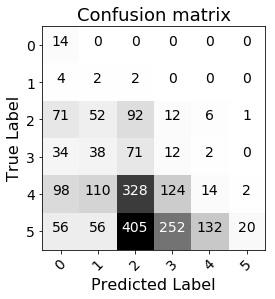

Prompt:  Which implementation -LRB- array-based vs. list-based -RRB- is preferred, and why? 
Score: 5.0, Score-Pred: 0
MA:  Link-based, because they are dynamic -LRB- no size constraints -RRB- 
MA_set: {'dynam', 'size', '-lrb-', '-rrb-', 'link-bas', 'constraint'}
SA:  List-based implementation is much easier to implement, and allows the stack to scale as necessary.  It is therefore the preferred implementation. 
SA_set: {'allow', 'easier', 'scale', 'list-bas', 'implement', 'much', 'prefer', 'stack', 'therefor', 'necessari'}
Prompt:  Briefly, how does selection sort work? 
Score: 5.0, Score-Pred: 1
MA:  It selects the minimum from an array and places it on the first position, then it selects the minimum from the rest of the array and places it on the second position, and so forth. 
MA_set: {'minimum', 'first', 'forth', 'array', 'place', 'second', 'select', 'rest', 'posit'}
SA:  A selection sort scrolls through the data structure looking for the lowest -LRB- or highest -RRB- unsorted pie

In [12]:
idxs3 = np.logical_and(results['y_pred_raw'] < 0.2, results['y_true'] > 4.0)
print(len(df_en[idxs3]))
cm3 = stats.cm(results['y_true'], results['y_pred'])
stats.plot_confusion_matrix(cm3, classes=np.arange(6))

wo.inspect_results(df_en, results['y_true'], results['y_pred'], idxs3, results['sets'], size=10)

## How much of difference does stopword Removal Make?

             precision    recall  f1-score   support

        0.0       0.16      0.93      0.28        14
        1.0       0.02      0.62      0.04         8
        2.0       0.13      0.55      0.21       234
        3.0       0.04      0.13      0.06       157
        4.0       0.10      0.02      0.03       676
        5.0       0.79      0.01      0.02       921

avg / total       0.41      0.10      0.05      2010

Pearson's R: 0.4151507471775712
Cohen's Kappa: -0.011971140392904367
MAE: 1.8796019900497511
Accuracy: 9.50%
Precision: 41.19%
Recall: 9.50%
F1-Measure: 5.35%


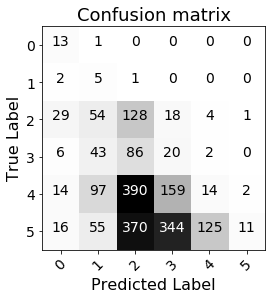

In [13]:
pipeline_phases1 = { 'case_normalization' : pp.case_normalization,
                     'punctuation_removal' : pp.punctuation_removal,
                     'stemming' : pp.create_stemmer(pp.EN_STEMMER)}

pipeline1 = pp.create_pipeline(pipeline_phases1, pp.whitespace_tokenize)

results1 = wo.execute_word_overlap_model(df_en, pipeline1, wo.faucett_coefficient)

stats.print_all_stats(results1['y_true'], results1['y_pred'])
stats.plot_confusion_matrix(stats.cm(results1['y_true'], results1['y_pred']), classes=np.arange(6))

### Results

Removing Stopwords does have an impact on precision. This is due to the fact that in this approach any stopword can only make up at maximum one word in the sentence set of tokens.

## How good is this method for Fill-In-The-Blank Style Questions?

Hypothesis: it should be quite good for short model answers and short student responses, at least compared to longer answers, since FITB type questions usually are all or nothing affairs.

432
             precision    recall  f1-score   support

        0.0       0.12      1.00      0.21        13
        1.0       0.00      0.00      0.00        15
        2.0       0.07      0.21      0.11        33
        3.0       0.00      0.00      0.00         8
        4.0       0.06      0.04      0.05        45
        5.0       1.00      0.39      0.56       318

avg / total       0.75      0.34      0.43       432

Pearson's R: 0.5089752071767977
Cohen's Kappa: 0.1198181960661392
MAE: 1.7615740740740742
Accuracy: 33.80%
Precision: 75.13%
Recall: 33.80%
F1-Measure: 43.28%


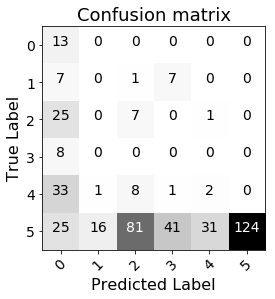

In [14]:
## Load Dataset
df_fitb = pd.read_csv("../../../datasets/final/en/asag_v2_en_fitb.csv", sep='~')
print(len(df_fitb))
df_fitb.head(1)

results_fitb = wo.execute_word_overlap_model(df_fitb, pipeline, wo.faucett_coefficient)

stats.print_all_stats(results_fitb['y_true'], results_fitb['y_pred'])
stats.plot_confusion_matrix(stats.cm(results_fitb['y_true'], results_fitb['y_pred']), classes=np.arange(6))

### Results

It is vastly better at FITB style questions, reaffirming the notion that those questions are fundamentally different than the rest; that is they are in their own category. Whether or not using FITB methods for dealing with such questions is the best approach remains to be seen.

## German Evaluation

2010


ID  AID  QID                                             Prompt  \
0  1.1    1    1  Welche Rolle spielt ein Prototyp-Programm bei ...   

                                                  MA  \
0  Um das Verhalten von Teilen des gewünschten So...   

                                                 MA2  \
0  um ein Beispiel und Feedback zur Funktionsweis...   

                                                 MA3  \
0  als Konzeptnachweis dienen und veranschauliche...   

                                          NA  \
0  um Fehler zu finden oder Daten zu sammeln   

                                                  SA  MyScore  \
0  In dem Prototyp-Programm werden Probleme mit h...        4   

           Feedback Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect            NaN    3.5             2             1

             precision    recall  f1-score   support

        0.0       0.03      1.00      0.05        14
        1.0       0.00      0.12      0.01         8
        2.0       0.08      0.28      0.13       234
        3.0       0.02      0.03      0.02       157
        4.0       0.06      0.01      0.01       676
        5.0       0.90      0.01      0.02       921

avg / total       0.44      0.05      0.03      2010

Pearson's R: 0.3554320598036985
Cohen's Kappa: -0.02586406742252434
MAE: 2.611940298507463
Accuracy: 4.93%
Precision: 44.40%
Recall: 4.93%
F1-Measure: 3.04%


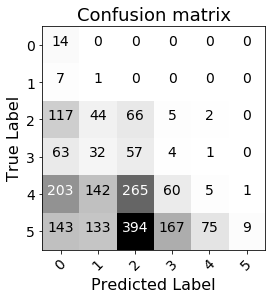

In [15]:
## Load Dataset
df_de = pd.read_csv("../../../datasets/final/de/asag_v2_de_filter.csv", sep='~')
print(len(df_de))
display(df_de.head(1))

pipeline_phases2 = { 'case_normalization' : pp.case_normalization,
                    'punctuation_removal' : pp.punctuation_removal,
                    'remove_stopwords' : pp.create_remove_stopwords(pp.DE_STOPS),
                    'stemming' : pp.create_stemmer(pp.DE_STEMMER)}

pipeline2 = pp.create_pipeline(pipeline_phases2, pp.whitespace_tokenize)

results2 = wo.execute_word_overlap_model(df_de, pipeline2, wo.faucett_coefficient)

stats.print_all_stats(results2['y_true'], results2['y_pred'])
stats.plot_confusion_matrix(stats.cm(results2['y_true'], results2['y_pred']), classes=np.arange(6))

## Spanish Evaluation

2010


ID  AID  QID                                             Prompt  \
0  1.1    1    1  ¿Cuál es el papel de un programa prototipo en ...   

                                                  MA  \
0  Para simular el comportamiento de porciones de...   

                                                 MA2  \
0  para proporcionar un ejemplo y retroalimentaci...   

                                                 MA3  \
0  para servir como prueba de concepto e ilustrar...   

                                         NA  \
0  para encontrar errores o recopilar datos   

                                                  SA  MyScore  \
0  Los problemas de alto riesgo se abordan en el ...        4   

           Feedback Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect            NaN    3.5             2             1

             precision    recall  f1-score   support

        0.0       0.06      1.00      0.12        14
        1.0       0.00      0.12      0.01         8
        2.0       0.10      0.38      0.16       234
        3.0       0.02      0.04      0.03       157
        4.0       0.07      0.01      0.02       676
        5.0       0.95      0.02      0.04       921

avg / total       0.47      0.07      0.05      2010

Pearson's R: 0.451347115203463
Cohen's Kappa: -0.030571574122919998
MAE: 2.1139303482587066
Accuracy: 7.01%
Precision: 47.23%
Recall: 7.01%
F1-Measure: 4.80%


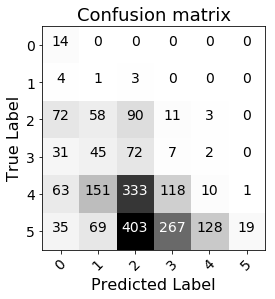

In [16]:
## Load Dataset
df_es = pd.read_csv("../../../datasets/final/es/asag_v2_es_filter.csv", sep='~')
print(len(df_es))
display(df_es.head(1))

pipeline_phases3 = { 'case_normalization' : pp.case_normalization,
                    'punctuation_removal' : pp.punctuation_removal,
                    'remove_stopwords' : pp.create_remove_stopwords(pp.ES_STOPS),
                    'stemming' : pp.create_stemmer(pp.ES_STEMMER)}

pipeline3 = pp.create_pipeline(pipeline_phases3, pp.whitespace_tokenize)

results3 = wo.execute_word_overlap_model(df_es, pipeline3, wo.faucett_coefficient)

stats.print_all_stats(results3['y_true'], results3['y_pred'])
stats.plot_confusion_matrix(stats.cm(results3['y_true'], results3['y_pred']), classes=np.arange(6))